<a href="https://www.kaggle.com/code/nigamshitij/embeddings-for-movie-recommendations?scriptVersionId=176965235" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
#boilerplate

from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

# get data
path = untar_data(URLs.ML_100k)
# path = Path('/kaggle/input/movielens-100k-dataset/ml-100k')

In [7]:
# testing dotproducts
movie1 = np.array([0.98, 0.90, -0.90])
user1 = np.array([0.90, 0.80, -0.60])
print("User1 x Movie1: ", (user1*movie1).sum()) # sumproducts

User1 x Movie1:  2.1420000000000003


In [8]:
# check files
path.ls()

# delimiter detector

# import csv
# sniffer = csv.Sniffer()
# dialect = sniffer.sniff('quarter, dime, nickel, penny')
# print(dialect.delimiter)
# # returns ','

# with open(path/'u.item', newline='') as f:
#     reader = csv.reader(f)
#     dialect = []
#     for row in reader:
#     # do something here with `row`
#         dialect = csv.Sniffer().sniff(row[0], delimiters=';,|')
#         break

(#23) [Path('/root/.fastai/data/ml-100k/ua.test'),Path('/root/.fastai/data/ml-100k/u2.test'),Path('/root/.fastai/data/ml-100k/u1.test'),Path('/root/.fastai/data/ml-100k/u.item'),Path('/root/.fastai/data/ml-100k/u3.base'),Path('/root/.fastai/data/ml-100k/README'),Path('/root/.fastai/data/ml-100k/allbut.pl'),Path('/root/.fastai/data/ml-100k/u.occupation'),Path('/root/.fastai/data/ml-100k/u.info'),Path('/root/.fastai/data/ml-100k/u1.base')...]

In [9]:
# get ratings
ratings_df = pd.read_csv(
    path/'u.data',
    delimiter = '\t', 
    header = None,
    names = ['user', 'movie', 'rating', 'timestamp']
)
print(ratings_df.head())

# get movies
movies_df = pd.read_csv(
    path/'u.item', 
    header = None, 
    encoding = 'latin-1', 
    delimiter = '|',
    usecols = (0,1),
    names = ('movie', 'title')
)
print(movies_df.head())

# merge
ratings_df = ratings_df.merge(movies_df)
print(ratings_df.head())

   user  movie  rating  timestamp
0   196    242       3  881250949
1   186    302       3  891717742
2    22    377       1  878887116
3   244     51       2  880606923
4   166    346       1  886397596
   movie              title
0      1   Toy Story (1995)
1      2   GoldenEye (1995)
2      3  Four Rooms (1995)
3      4  Get Shorty (1995)
4      5     Copycat (1995)
   user  movie  rating  timestamp                       title
0   196    242       3  881250949                Kolya (1996)
1   186    302       3  891717742    L.A. Confidential (1997)
2    22    377       1  878887116         Heavyweights (1994)
3   244     51       2  880606923  Legends of the Fall (1994)
4   166    346       1  886397596         Jackie Brown (1997)


In [10]:
# CollabDataLoaders.from_df??

# user_name - default is first column
# item_name - default is second column
# rating - default is third column

dataloader = CollabDataLoaders.from_df(
    ratings = ratings_df,
    user_name = 'user',
    item_name = 'title', # name of the column containing the item (defaults to the second column)
    rating_name = 'rating',
    bs = 64
)
dataloader.show_batch()

,user,title,rating
0,752,In & Out (1997),4
1,810,Money Talks (1997),3
2,308,Mimic (1997),2
3,354,"Grand Day Out, A (1992)",3
4,326,Once Upon a Time in the West (1969),2
5,379,Back to the Future (1985),5
6,385,Vertigo (1958),5
7,13,Army of Darkness (1993),1
8,244,Dave (1993),1
9,325,"Abyss, The (1989)",1


In [11]:
# create latent factor dummies
n_users = len(dataloader.classes['user'])
n_movies = len(dataloader.classes['title'])
n_factors = 5

print("No. of users is: ", n_users)
print("No. of movies is: ", n_movies)

# initialize factors with random numbers
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

print("user factor shape: ", user_factors.shape)
print("movie factor shape: ", movie_factors.shape)

No. of users is:  944
No. of movies is:  1665
user factor shape:  torch.Size([944, 5])
movie factor shape:  torch.Size([1665, 5])


In [12]:
# conceptual one hot encoding tests as precursor to embedding matrix
one_hot_3 = one_hot(3, n_users).float()

for i in range(len(one_hot_3)):
    print(one_hot_3[i])
    if i == 5: break

# print(one_hot_3)
# print(user_factors)
# print(user_factors.t())
        
print("one-hot 3 shape: ", one_hot_3.shape)
print("uf shape: ", user_factors.shape)
print("uftransposed shape: ", user_factors.t().shape)
print("uftransposed @ one_hot_3: ", user_factors.t() @ one_hot_3)
print("uftransposed @ one_hot_3 shape: ", (user_factors.t() @ one_hot_3).shape)
# print("user factors * one_hot_3: ", user_factors.t() * one_hot_3)

tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
one-hot 3 shape:  torch.Size([944])
uf shape:  torch.Size([944, 5])
uftransposed shape:  torch.Size([5, 944])
uftransposed @ one_hot_3:  tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])
uftransposed @ one_hot_3 shape:  torch.Size([5])


In [13]:
# torch.t??
# Create dot product module

class DotProduct(Module):
    
    # initialize parameters
    def __init__(self, n_users, n_movies, n_factors, y_range = (0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
        print("user factors shape: ", user_factors.shape)
        print("movie factors shape: ", movie_factors.shape)
#         self.model.to('cuda')
    
    # define forward pass function for a dotproduct
    def forward(self, x):
        users = self.user_factors(x[:,0]) # get all rows, first column
        movies = self.movie_factors(x[:,1]) # get all rows, second column
        return sigmoid_range((users * movies).sum(dim = 1), *self.y_range)
    
# illustration of what will get passed into as 'x' via dataloader
# check one batch of x and y that goes into dotproduct
x, y = dataloader.one_batch()
x[0], y[0], x.shape, y.shape
# x will get passed into dotproduct
# x will be a tensor of dimensions 64 (batch size) and 2 columns (users and movies)

(tensor([697, 294]),
 tensor([5], dtype=torch.int8),
 torch.Size([64, 2]),
 torch.Size([64, 1]))

In [14]:
sigmoid_range??

Signature: sigmoid_range(x, low, high)
Source:   
def sigmoid_range(x, low, high):
    "Sigmoid function with range `(low, high)`"
    return torch.sigmoid(x) * (high - low) + low
File:      /opt/conda/lib/python3.10/site-packages/fastai/layers.py
Type:      function

In [15]:
# set up model and learner instances
dot_product_model = DotProduct(n_users, n_movies, 50)
learner = Learner(
    dls = dataloader,
    model = dot_product_model,
    loss_func = MSELossFlat()
#     lr = 0.001 # default
)
learner.fit_one_cycle(
    n_epoch = 5,
    lr_max = 0.005
)

user factors shape:  torch.Size([944, 5])
movie factors shape:  torch.Size([1665, 5])


epoch,train_loss,valid_loss,time
0,0.965341,0.969212,00:09
1,0.856568,0.879686,00:08
2,0.674868,0.864997,00:08
3,0.473531,0.876663,00:08
4,0.363121,0.882251,00:08


In [16]:
### explore for a batch
# user_factors = Embedding(n_users, 5)
# x, y = dataloader.one_batch()
# users = user_factors(x[:,0])
# users.shape, x[:,0]

# Add Bias model
class DotProductBias(Module):
    
    def __init__(self, n_users, n_movies, n_factors, y_range = (0, 5.5)):
        
        # base parameter embeddings (initialized randomly, 50 per user, 50 per movie)
        # each row becomes uniquely attached to a specific user/movie per index
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
        # bias embeddings (initialized randomly - 1 per user, 1 per movie)
        self.user_bias = Embedding(n_users, 1) # one column only
        self.movie_bias = Embedding(n_movies, 1) # same as above
        
        # range for squishing into sigmoid
        self.y_range = y_range
    
    def forward(self, x):
        
        # x[:,0] contains the indices we want to look up in the embedding layer
        # user_factors(x[:,0]) will return a tensor of embeddings we want corresponding to those indices
        # users * movies will multiply those indices for that batch
        # user_bias(x[:,0])
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        result = (users * movies).sum(dim = 1, keepdim = True)
        result += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        
        return sigmoid_range(result, *self.y_range)

In [17]:
# initialize model
# dpg = dotproductbias
dpb_model = DotProductBias(n_users, n_movies, 50)

# dpg = dotproductbias
# initialize learner
dpb_learner = Learner(
    dls = dataloader,
    model = dpb_model,
    loss_func = MSELossFlat()
#     lr = 0.001 # default
)
dpb_learner.fit_one_cycle(
    n_epoch = 5,
    lr_max = 0.005,
    wd = 0.1 # add weight decay too 
)

epoch,train_loss,valid_loss,time
0,0.946764,0.932704,00:09
1,0.851858,0.862306,00:09
2,0.729733,0.822246,00:09
3,0.607089,0.810118,00:09
4,0.492538,0.811284,00:09


In [18]:
# import torch.nn as nn

# define function for parameter creation with random initialization
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

# create new DPB module using parameters
class DPB(Module):
    
    def __init__(self, n_users, n_movies, n_factors, y_range = (0.5, 5.5)):
        
        # factors
        self.user_factors = create_params([n_users, n_factors])
        self.movie_factors = create_params([n_movies, n_factors])
        
        # biases
        self.user_bias = create_params([n_users])
        self.movie_bias = create_params([n_movies])
        
        # range
        self.y_range = y_range
    
    def forward(self, x):
        
        # for embeddings you pass indices as a function
        # for Parameters, you pass indices with [] like a list
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        
        # calculate results
        result = (users * movies).sum(dim = 1)
        result += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        
        # return result with sigmoid and range constraints
        return sigmoid_range(result, *self.y_range)

    
dpb_param_model = DPB(n_users, n_movies, 50)
dpb_param_learner = Learner(
    dls = dataloader,
    model = dpb_param_model,
    loss_func = MSELossFlat()
)
dpb_param_learner.fit_one_cycle(
    n_epoch = 5,
    lr_max = 0.005,
    wd = 0.1
)

epoch,train_loss,valid_loss,time
0,0.926471,0.909123,00:09
1,0.827756,0.842706,00:09
2,0.709647,0.811240,00:09
3,0.579846,0.808030,00:09
4,0.476882,0.810326,00:09


In [19]:
# some interpretations and analysis

# return all biases in a single tensor
movie_bias = dpb_param_learner.model.movie_bias.squeeze()
print(movie_bias)

# get indexes of lowest biases
lowest_indexes = movie_bias.argsort()[:5]
print(lowest_indexes) # each of these indexes are associated with specific movies

# look up indexes in dataloaders to get corresponding titles
for i in lowest_indexes:
    print(dataloader.classes['title'][i])

# get indexes of lowest biases
highest_indexes = movie_bias.argsort(descending = True)[:5]
print(highest_indexes) # each of these indexes are associated with specific movies

# look up indexes in dataloaders to get corresponding titles
for i in highest_indexes:
    print(dataloader.classes['title'][i])

tensor([-0.0026, -0.1086, -0.0420,  ..., -0.0473,  0.0370,  0.0227],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([ 855,  850,  256,  140, 1329], device='cuda:0')
Leave It to Beaver (1997)
Lawnmower Man 2: Beyond Cyberspace (1996)
Cable Guy, The (1996)
Beautician and the Beast, The (1997)
Showgirls (1995)
tensor([1282, 1216, 1318,  622, 1501], device='cuda:0')
Schindler's List (1993)
Rear Window (1954)
Shawshank Redemption, The (1994)
Good Will Hunting (1997)
Titanic (1997)


title
'Til There Was You (1997)                  9
1-900 (1994)                               5
101 Dalmatians (1996)                    109
12 Angry Men (1957)                      125
187 (1997)                                41
                                        ... 
Young Guns II (1990)                      44
Young Poisoner's Handbook, The (1995)     41
Zeus and Roxanne (1997)                    6
unknown                                    9
Á köldum klaka (Cold Fever) (1994)         1
Name: rating, Length: 1664, dtype: int64

['Star Wars (1977)' 'Contact (1997)']

tensor([1399,  334])

tensor([[ 0.1315,  0.2538, -0.0804, -0.1952,  0.1337, -0.0181,  0.3083, -0.2834,
         -0.2047, -0.6177,  0.4664, -0.4007, -0.4640, -0.4394, -0.0638,  0.1555,
         -0.1285, -0.2583,  0.2928,  0.2759,  0.6820, -0.1118, -0.1487, -0.4820,
          0.0679,  0.1541,  0.1148, -0.0040,  0.6159, -0.1581,  0.2191,  0.1385,
          0.1432, -0.2538,  0.0647, -0.5443,  0.1008,  0.5730, -0.1141, 

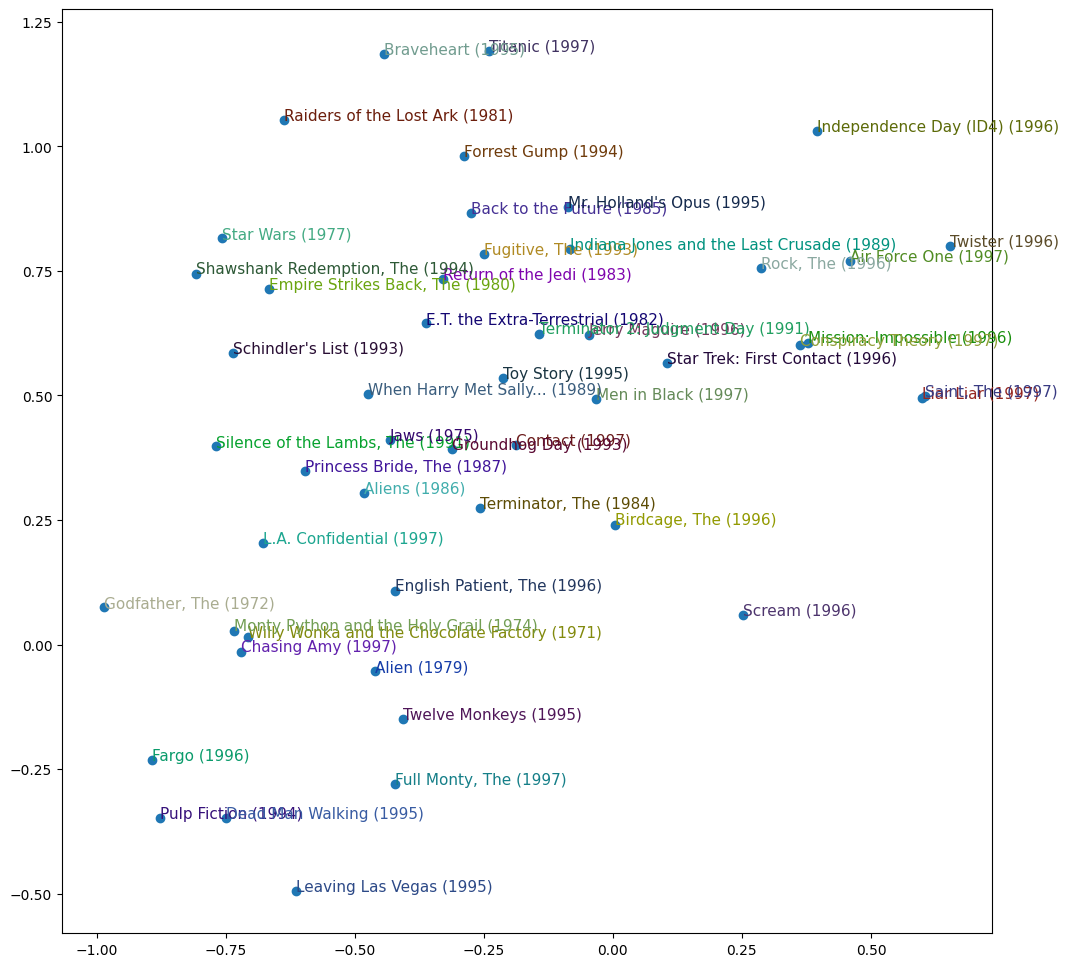

In [20]:
# principal component analysis

# group movies by total # of ratings per movie
movies_grouped_by_ratings_count = ratings_df.groupby('title')['rating'].count()
print(movies_grouped_by_ratings_count)
print()

# get 1000 movies with highest ratings
most_rated_movies = movies_grouped_by_ratings_count.sort_values(ascending = False).index.values[:1000]
print(most_rated_movies[0:2])
print()

# get indexes for these movies
indexes_most_rated_movies = tensor([dpb_param_learner.dls.classes['title'].o2i[m] for m in most_rated_movies])
print(indexes_most_rated_movies[0:2])
print()

# get weights for these movies
weights_most_rated_movies = dpb_param_learner.model.movie_factors[indexes_most_rated_movies].cpu().detach()
print(weights_most_rated_movies[0:2]) # 50 weights per movie
print()

# get principle components
movie_weights_pca = weights_most_rated_movies.pca(3)
fac0, fac1, fac2 = movie_weights_pca.t()
print(fac0[0:2])

# extract 50 movies
indexes = list(range(50))
X = fac0[indexes]
Y = fac1[indexes]

# add to scatter plot
plt.figure(figsize = (12,12))
plt.scatter(X, Y)
for i, x, y in zip(most_rated_movies[indexes], X, Y):
    plt.text(x, y, i, color = np.random.rand(3)*0.7, fontsize = 11)
plt.show()

In [21]:
# try fast.ai for collab learner
# collab_learner??
fast_learner = collab_learner(
    dls = dataloader,
    n_factors = 50,
    y_range = (0.5, 5.5)
)
fast_learner.fit_one_cycle(
    n_epoch = 5,
    lr_max = 0.005,
    wd = 0.1
)

print(fast_learner.model)
# fast_learner.fit_one_cycle(n_epochs)

epoch,train_loss,valid_loss,time
0,0.927018,0.919094,00:08
1,0.847356,0.843566,00:08
2,0.688139,0.814875,00:09
3,0.583575,0.810304,00:09
4,0.472665,0.811362,00:08


EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)


In [22]:
# Learner.fit_one_cycle??

# extract movie biases using i_bias (item bias)
movie_bias = fast_learner.model.i_bias.weight.squeeze()

# extract indices for the top 5 biases
top_bias_movie_indices = movie_bias.argsort(descending = True)[:5]

# lookup in dictionary
for i in top_bias_movie_indices:
    print(dataloader.classes['title'][i])

print()
# get embedding distance

# extract movie factors using i_weight (item weights)
movie_factors = fast_learner.model.i_weight.weight

# extract index for shawshank redemption
index = dataloader.classes['title'].o2i['Shawshank Redemption, The (1994)']

# get distances using cosine similarity between shawshank and all other movies
distances = nn.CosineSimilarity(dim = 1)(movie_factors, movie_factors[index][None])

# get the index of the closest movie to Shawshank
index = distances.argsort(descending = True)[1]

# print the title of the movie closest to shawshank using dataloaders
dataloader.classes['title'][index]

Shawshank Redemption, The (1994)
Schindler's List (1993)
Rear Window (1954)
Good Will Hunting (1997)
Titanic (1997)



'Glory (1989)'

In [23]:
embedding_sizes = get_emb_sz(dataloader)
user_size, item_size = embedding_sizes
print("User_size: ", user_size[1], "| Item_size: ", item_size[1])

# deep learning - try multiple layers
class CollabNeuralNetwork(Module):
    
    def __init__(self, user_size, item_size, y_range = (0.5, 5.5), n_act = 100):
        
        # initialize embeddings
        self.user_factors = Embedding(*user_size)
        self.item_factors = Embedding(*item_size)
        
        # initialize nn layers (2 linear layers padded with relu)
        self.layers = nn.Sequential(
            # linear layer of size (user+item size), output sample size = n_act (# of activations), bias = false
            nn.Linear(in_features = user_size[1]+item_size[1], out_features = n_act),
            # apply relu to above layer
            nn.ReLU(),
            # linear layer with input size = n_act (# of activations in previous), output size = 1
            nn.Linear(in_features = n_act, out_features = 1)
        )
        self.y_range = y_range
    
    def forward(self, x):
        # use indices from dataloaders to retrieve embeddings (weights)
        embeddings = self.user_factors(x[:,0]), self.item_factors(x[:,1])
        # push embeddings into layer, concatenated into a single dimension
        x = self.layers(torch.cat(embeddings, dim = 1))
        # chuck it through a sigmoid :-)
        return sigmoid_range(x, *self.y_range)

# create model instance
collab_nn_model = CollabNeuralNetwork(*embedding_sizes)

# create learner
collab_nn_learner = Learner(
    dls = dataloader,
    model = collab_nn_model,
    loss_func = MSELossFlat()
)

# fit one cycle
collab_nn_learner.fit_one_cycle(
    n_epoch = 5,
    lr_max = 0.005,
    wd = 0.01
)

User_size:  74 | Item_size:  102


epoch,train_loss,valid_loss,time
0,0.945685,0.939798,00:09
1,0.888070,0.889651,00:09
2,0.859284,0.856944,00:09
3,0.803239,0.845183,00:09
4,0.760323,0.847392,00:09


In [ ]:
# torch.cat??
# nn.Linear??